In [4]:
import torch
import numpy as np
import math
import os
import matplotlib.pyplot as plt

In [5]:
num_notes = 128
num_time_shifts = 100
num_velocities = 32
message_dim = 2*num_notes + num_velocities + num_time_shifts
instrument_numbers = [0, 6, 40, 41, 42, 43, 45, 60, 68, 70, 71, 73]
num_instruments = len(instrument_numbers)

# Baseline LSTM definition

In [177]:
# Taken from https://pytorch.org/tutorials/beginner/transformer_tutorial.html.
# Only change is the view/expand in forward (accounts for batches)
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=10000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.shape[0], :].unsqueeze(1).expand(-1, x.shape[1], -1)
        return self.dropout(x)
        

# EnsembleLSTM: takes a history of MIDI messages 
# for instruments in an ensemble and generates a distribution for the next message,
# as well as the instrument who should issue the message
class EnsembleLSTM(torch.nn.Module):
    # CONSTRUCTOR
    # ARGUMENTS
    # message_dim: dimension of a MIDI message
    # embed_dim: dimension of message embedding
    # num_instruments: number of instrument labels
    # hidden_size: size of hidden LSTM state
    def __init__(self, message_dim, embed_dim, num_instruments, hidden_size):
        super(EnsembleLSTM, self).__init__()
        
        self.embed_dim = embed_dim
        
        self.lstm_input_dim = 2*embed_dim
        
        # We concatenate the tanhed instrument embedding to each input message.
        # We have num_instruments + 1 embeddings to account for the dummy instrument
        # associated with time shift events
        # We could potentially reduce the size of the instrument embedding, but
        # for now let's keep it the same size as the message embedding
        self.i_embedding = torch.nn.Embedding(num_instruments + 1, embed_dim)
        
        self.embedding = torch.nn.Embedding(message_dim, embed_dim)
        
        # A 3-layer LSTM takes the history of messages (concatenated with their
        # associated instrument encoding) and produces a decoding
        self.lstm = torch.nn.LSTM(self.lstm_input_dim, hidden_size, num_layers=3)

        # The decoding is passed through a linear layer to get the logits for the next message        
        self.message_logits = torch.nn.Linear(hidden_size, message_dim)
        
        # The decoding is passed through a different linear layer to get a query for
        # instrument-wise attention, which predicts which channel should generate
        # this message
        self.inst_query = torch.nn.Linear(hidden_size, embed_dim)
        
        # Indicates which channel is associated with each instrument
        self.position_encoding = PositionalEncoding(embed_dim)
    
    # forward: generates a probability distribution for the next MIDI message
    # and the channel that issues the message, given a message history for the instrument ensemble
    # ARGUMENTS
    # history: an LxBx2 tensor, where L is the length of the longest message history in
    # the batch, and B is the batch size. The first index along dimension 2 stores the
    # message number. The second stores the channel number. This should be END-PADDED
    # along dimension 0
    # mask: an LxB tensor, containing True in any locations where history contains
    # padding
    # instruments: a CxB tensor indicating the instrument number for each channel, where
    # C is the maximum number of channels in the batch. This should be END-PADDED along dimension 0.
    # The the last valid channel index should contain num_instruments (indicating the "time-shift instrument")
    # RETURN: two tensors. The first is LxBxD, representing the distribution for the next message at each time
    # step (need to take the softmax to get actual probabilities). The second is LxBxC, representing the
    # distribution for the next channel at each time step (need to take the softmax to get actual probabilities)
    def forward(self, history, mask, instruments):
        L = history.shape[0] # longest length
        B = history.shape[1] # batch size
        C = instruments.shape[0]
        assert(mask.shape == (L, B))
        
        # CxBxD
        inst_embed = torch.tanh(self.i_embedding(instruments))
        
        # LxBxD, instrument embedding associated with each message
        inst_tags = torch.gather(inst_embed, 0, history[:, :, 1].unsqueeze(2).expand(-1, -1, self.embed_dim))
        
        # LxBxD
        message_embed = self.embedding(history[:, :, 0])
        
        inputs = torch.cat((message_embed, inst_tags), dim=2)
        
        decoding, last_hidden = self.lstm(inputs)
        
        # LxBxD
        message_dist = self.message_logits(decoding)
        
        # CxLxBxD
        inst_queries = self.inst_query(decoding).unsqueeze(0).expand(C, -1, -1, -1)
        
        prods = inst_queries*self.position_encoding(inst_embed).unsqueeze(1).expand(-1, L, -1, -1)/self.embed_dim
        
        # Dot-product attention (LxBxC)
        channel_dist = torch.sum(prods, dim=3).permute(1, 2, 0)
        
        return message_dist, channel_dist
    
    # forward: generates a probability distribution for the next MIDI message
    # and the channel that should issue it, given the previous message and channel,
    # as well as the LSTM hidden state
    # ARGUMENTS
    # last_token: a 1x1x2 tensor. The first index along dimension 2 stores the
    # message number. The second stores the channel number
    # instruments: a Cx1 tensor indicating the instrument number for each channel, where C is the number of channels
    # The the last channel index should contain num_instruments (indicating the "time-shift instrument")
    # hidden: the last hidden state for the LSTM
    # RETURN: a 1x1x2 tensor, predicting the next message and the channel that should issue it, as well as the new
    def forward_generate(self, last_token, instruments, hidden):
        assert(last_token.shape == (1, 1, 2))
        C = instruments.shape[0]
        
        # Cx1xD
        inst_embed = torch.tanh(self.i_embedding(instruments))
        
        # 1x1xD, instrument embedding associated with each message
        inst_tags = torch.gather(inst_embed, 0, last_token[:, :, 1].unsqueeze(2).expand(-1, -1, self.embed_dim))
        
        # 1x1xD
        message_embed = self.embedding(last_token[:, :, 0])
        
        inputs = torch.cat((message_embed, inst_tags), dim=2)
        
        decoding, new_hidden = self.lstm(inputs, hidden)
        
        # 1x1xD
        message_dist = self.message_logits(decoding)
        
        # Cx1x1xD
        inst_queries = self.inst_query(decoding).unsqueeze(0).expand(C, -1, -1, -1)
        
        prods = inst_queries*self.position_encoding(inst_embed).unsqueeze(1)/self.embed_dim
        
        # Dot-product attention (1x1xC)
        channel_dist = torch.sum(prods, dim=3).permute(1, 2, 0)
        
        #message = torch.multinomial(torch.softmax(message_dist.flatten(), dim=0), 1)
        #channel = torch.multinomial(torch.softmax(channel_dist.flatten(), dim=0), 1)
        
        message = torch.argmax(torch.softmax(message_dist.flatten(), dim=0))
        channel = torch.argmax(torch.softmax(channel_dist.flatten(), dim=0))
        
        ret = torch.cat((message.view(1, 1, 1), channel.view(1, 1, 1)), dim=2)
        
        return ret, new_hidden

# Tests for baseline LSTM
We train with model.eval() to disable dropout, since these tests try to get the model to overfit to a small sequence

Get the model to overfit to a single song

In [178]:
embed_dim = 256
hidden_size = 1024

grad_clip = 10

model = EnsembleLSTM(message_dim, embed_dim, num_instruments, hidden_size)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))
    
model.eval() # Training with eval just to see if we can overfit without dropout
pass

In [175]:
model.load_state_dict(torch.load('overfit_single_song.pth'))

<All keys matched successfully>

In [179]:
recording = np.load('preprocessed_data_unified/recording318.npy', allow_pickle=True)
instruments_np = np.load('preprocessed_data_unified/instruments318.npy', allow_pickle=True)

nsamples = 100

history = torch.tensor(recording[:nsamples], dtype=torch.long).view(-1, 1, 2)
mask = torch.zeros((history.shape[0], history.shape[1]), dtype=torch.bool)
instruments = torch.tensor([instrument_numbers.index(i) for i in instruments_np] + [num_instruments], dtype=torch.long).view(-1, 1)

num_channels = instruments.shape[0]

batch_size = 1
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 500
train_losses = np.zeros(epochs)

target_messages = history[1:, :, 0].flatten()
target_channels = history[1:, :, 1].flatten()

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    
    message_logits, channel_logits = model(history[:-1], mask[:-1], instruments)
    
    loss = loss_fn(message_logits.view(-1, message_dim), target_messages) + \
           loss_fn(channel_logits.view(-1, num_channels), target_channels)
                
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses[epoch] = loss.data
    print('Loss: %f' %(loss.data))

Starting epoch 0
Loss: 7.567419
Starting epoch 1
Loss: 7.284444
Starting epoch 2
Loss: 5.026549
Starting epoch 3
Loss: 4.377564
Starting epoch 4
Loss: 4.178999
Starting epoch 5
Loss: 4.053557
Starting epoch 6
Loss: 4.051679
Starting epoch 7
Loss: 4.050501
Starting epoch 8
Loss: 4.027046
Starting epoch 9
Loss: 4.015304
Starting epoch 10
Loss: 4.010924
Starting epoch 11
Loss: 4.001538
Starting epoch 12
Loss: 3.993667
Starting epoch 13
Loss: 3.989302
Starting epoch 14
Loss: 3.988303
Starting epoch 15
Loss: 3.987134
Starting epoch 16
Loss: 3.986350
Starting epoch 17
Loss: 3.986148
Starting epoch 18
Loss: 3.976891
Starting epoch 19
Loss: 3.971772
Starting epoch 20
Loss: 3.964532
Starting epoch 21
Loss: 3.962311
Starting epoch 22
Loss: 3.958121
Starting epoch 23
Loss: 3.954402
Starting epoch 24
Loss: 3.952146
Starting epoch 25
Loss: 3.949122
Starting epoch 26
Loss: 3.943463
Starting epoch 27
Loss: 3.936802
Starting epoch 28
Loss: 3.930243
Starting epoch 29
Loss: 3.922114
Starting epoch 30
Lo

In [182]:
torch.save(model.state_dict(), 'overfit_single_song.pth')

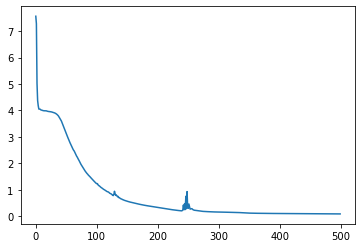

In [180]:
plt.plot(train_losses)

In [181]:
# Sample from model
gen_history = history[0].unsqueeze(0)
mask = torch.zeros((1, 1), dtype=torch.bool)
model.eval() # Turns off the dropout for evaluation. Need to do this to get repeatable evaluation outputs

# Move forward in time
wrong_cnt = 0
hidden = (torch.zeros(3, 1, hidden_size), torch.zeros(3, 1, hidden_size))
for t in range(0, history.shape[0] - 1):
    ret, hidden = model.forward_generate(gen_history[-1].view(1, 1, 2), instruments, hidden)
    
    gen_history = torch.cat((gen_history, ret), dim=0)
    
    if gen_history[-1, 0, 0] != history[t + 1, 0, 0]:
        print('Wrong message at time %d!' %(t))
        wrong_cnt += 1
        
    if gen_history[-1, 0, 1] != history[t + 1, 0, 1]:
        print('Wrong instrument at time %d!' %(t))
        wrong_cnt += 1
    
    mask = torch.cat((mask, torch.zeros((1, 1), dtype=torch.bool)), dim=0)

print(wrong_cnt)

Wrong instrument at time 90!
Wrong instrument at time 91!
Wrong instrument at time 96!
Wrong instrument at time 98!
4


In [ ]:
print(gen_history[:, 0, 0].flatten())
print(history[:, 0, 0].flatten())

In [44]:
np.save('test_history.npy', gen_history.squeeze(1).detach().numpy())
np.save('test_instruments.npy', [instrument_numbers[i] for i in instruments[:-1, 0]])

# Custom dataset class

In [8]:
# Custom Dataset class
class MIDIDataset(torch.utils.data.Dataset):
    # CONSTRUCTOR: creates a list of recording files and a list
    # of instrument files in root_dir. Assumes that the directory
    # contains recording0.npy to recordingM.npy,
    # as well as instruments0.npy to instrumentsM.npy
    # ARGUMENTS
    # root_dir: the directory to search
    def __init__(self, root_dir, transform=None):
        files = os.listdir(root_dir)
        self.recordings = []
        self.instrument_files = []
        for file in files:
            if 'recording' in file:
                self.recordings.append(os.path.join(root_dir, file))
            elif 'instruments' in file:
                self.instrument_files.append(os.path.join(root_dir, file))
                
        assert(len(self.recordings) == len(self.instrument_files))
        self.recordings.sort()
        self.instrument_files.sort()
        self.transform = transform

    # __len__
    # RETURN: the number of recording files in the dataset
    def __len__(self):
        return len(self.recordings)

    # __getitem__
    # ARGUMENTS
    # idx: indicates which file to get
    # RETURN: an instance with keys 'instruments', 'history'
    # instance['history'] is an Lx2 numpy array containing messages and associated channels
    # instance['instruments'] a numpy array of instrument numbers
    def __getitem__(self, idx):
        instance = {'history': np.load(self.recordings[idx], allow_pickle=True), \
                    'instruments': np.load(self.instrument_files[idx], allow_pickle=True)}
        
        if self.transform:
            instance = self.transform(instance)
            
        return instance

In [9]:
# collate_fn: takes a list of samples from the dataset and turns them into a batch.
# ARGUMENTS
# batch: a list of dictionaries
# RETURN: a sample with keys 'history', 'instruments', and 'mask'
# sample['history']: an LxBx2 tensor containing messages
# sample['instruments']: a CxB tensor containing instrument numbers for each channel
# sample['mask']: an LxB tensor containing False where a message is
# valid, and True where it isn't (accounts for variable length sequences
# and zero padding)
# sample['nchan']: a length B tensor containing the number of channels for each batch
# element (including the dummy time-shift channel)
def collate_fn(batch):
    batch_size = len(batch)
    
    # We size our tensors to accomodate the longest sequence and the largest number of channels
    # (including the dummy time shift channel)
    max_channels = max([instance['instruments'].shape[0] for instance in batch]) + 1
    longest_len = max([instance['history'].shape[0] for instance in batch])

    sample = {'history': torch.zeros((longest_len, batch_size, 2), dtype=torch.long), \
              'instruments': torch.zeros((max_channels, batch_size), dtype=torch.long), \
              'mask': torch.ones((longest_len, batch_size), dtype=torch.bool), \
              'nchan': torch.zeros(batch_size, dtype=torch.long)}

    for b, instance in enumerate(batch):
        instrument_idx = [instrument_numbers.index(i) for i in instance['instruments']]
        
        sample['instruments'][:len(instrument_idx), b] = torch.tensor(instrument_idx, dtype=torch.long)
        # Add dummy channel
        sample['instruments'][len(instrument_idx), b] = num_instruments
        
        # +1 to account for udmmy channel
        sample['nchan'][b] = len(instrument_idx) + 1
        
        seq_length = instance['history'].shape[0]
        sample['history'][:seq_length, b] = torch.tensor(instance['history'], dtype=torch.long)
        sample['mask'][:seq_length, b] = False
            
    return sample

# Train the model

In [41]:
embed_dim = 256
hidden_size = 1024

grad_clip = 10

model = EnsembleLSTM(message_dim, embed_dim, num_instruments, hidden_size)
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -grad_clip, grad_clip))

In [27]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
batch_size = 1
learning_rate = 0.001
chunk_size = 200

dataset = MIDIDataset('preprocessed_data_unified')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

loss_fn = torch.nn.CrossEntropyLoss(reduction='sum')
epochs = 20
train_losses = np.zeros(epochs)
test_losses = np.zeros(epochs) # TODO: train/test split

model.train()

for epoch in range(epochs):
    print('Starting epoch %d' %(epoch))
    n_iter = 0
    for b, batch in enumerate(dataloader):
        max_seq_length = batch['history'].shape[0]
        
        num_targets = max_seq_length - 1 # Messages start from t = 0, but we start generating at t = 1
            
        print('Starting iteration %d' %(b))
        
        message_logits, channel_logits = model(batch['history'][:-1], batch['mask'][:-1], batch['instruments'])
        
        target_mask = torch.logical_not(batch['mask'][1:])
        
        num_valid_targets = target_mask.sum()
        
        target_messages = batch['history'][1:, :, 0][target_mask]
    
        message_loss = loss_fn(message_logits[target_mask], target_messages)/num_valid_targets
        
        channel_losses = torch.zeros(batch_size)
        
        for i in range(batch_size):
            channel_logits_i = channel_logits[:, :, :batch['nchan'][i]][target_mask]
            target_channels = batch['history'][1:, i, 1][target_mask]
            channel_losses[i] = loss_fn(channel_logits_i, target_channels)/num_valid_targets
            
        loss = message_loss + channel_losses

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses[epoch] = loss.data
    
    torch.save(model.state_dict(), 'trained_models_12_3/epoch' + str(epoch) + '.pth')
    train_losses[epoch] /= n_iter
    print('Loss: %f' %(train_losses[epoch]))

In [ ]:
plt.plot(train_losses)

# Sample from the model

In [38]:
model.load_state_dict(torch.load('trained_models_12_2/epoch19.pth'))

<All keys matched successfully>

In [ ]:
model.eval() # Disable dropout to make results repeatable

time_steps = 200 # How many time steps do we sample?

# Start with a time shift
gen_history = torch.zeros((1, 1, 2), dtype=torch.long)
gen_history[0, 0, 0] = 387

# Violin
instruments = torch.zeros((2, 1), dtype=torch.long)
instruments[0, 0] = 2
instruments[1, 0] = num_instruments
    
hidden = (torch.zeros(3, 1, hidden_size), torch.zeros(3, 1, hidden_size))
for t in range(0, time_steps):
    ret, hidden = model.forward_generate(gen_history[-1].view(1, 1, 2), instruments, hidden)
    gen_history = torch.cat((gen_history, ret), dim=0)

In [ ]:
np.save('gen_history.npy', gen_history.squeeze(1).detach().numpy())
np.save('gen_instruments.npy', [instrument_numbers[i] for i in instruments[:-1, 0]])